In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')
plt.style.use('ggplot')

In [2]:
from __future__ import absolute_import
from __future__ import print_function

import random
from keras.models import Sequential
import time
from keras.optimizers import Adam,RMSprop
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
import seaborn as sns
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.optimizers import *
from keras.engine.topology import Layer
from keras import backend as K
from keras.regularizers import l2

num_classes = 24
epochs = 20

In [3]:
import numpy.random as rng
def initialize_weights(shape,dtype,name=None):
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)

def initialize_bias(shape,dtype,name=None):

    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

In [4]:
def create_model(input_shape):
  left_input = Input(input_shape)
  right_input = Input(input_shape)
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(Activation(activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(64, kernel_size=(3, 3)))
  model.add(BatchNormalization())
  model.add(Activation(activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(128))
  model.add(BatchNormalization())
  model.add(Activation(activation='relu'))

  encoded_l = model(left_input)
  encoded_r = model(right_input)

  L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
  L1_distance = L1_layer([encoded_l, encoded_r])
  prediction = Dense(1,activation='sigmoid')(L1_distance)

 

  siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

  return siamese_net

In [19]:
model = create_model((28, 28, 1))
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128)          224640      input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128)          0           sequential_1[0][0]    

In [20]:
optimizer = Adam(lr = 0.00006)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics='accuracy')

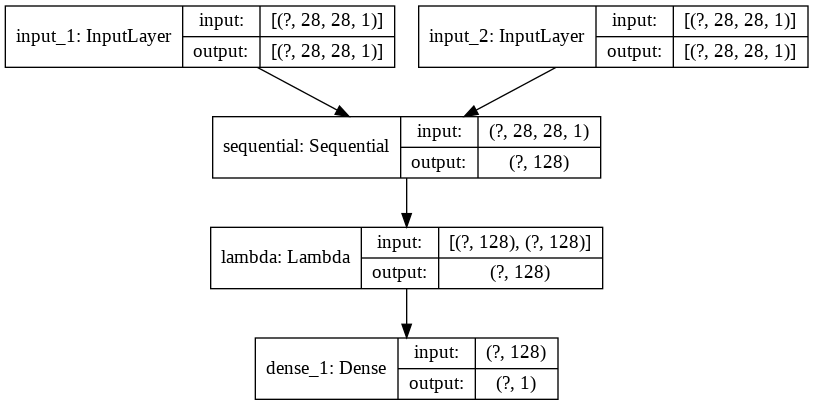

In [7]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [8]:
train = pd.read_csv('/content/drive/MyDrive/SIGNS MNIST/sign_mnist_train.csv')
test = pd.read_csv('/content/drive/MyDrive/SIGNS MNIST/sign_mnist_test.csv')

train_labels =train['label']
train_images =train.drop(['label'],axis=1)

train_data = np.array(train_images).reshape((27455,28,28,1))
train_label = np.array(train_labels)
test_x = np.array(test)

In [9]:
df = train.drop_duplicates(subset = ["label"])
print(df)

    label  pixel1  pixel2  pixel3  ...  pixel781  pixel782  pixel783  pixel784
0       3     107     118     127  ...       206       204       203       202
1       6     155     157     156  ...       175       103       135       149
2       2     187     188     188  ...       198       195       194       195
4      13     164     167     170  ...       157       163       164       179
5      16     161     168     172  ...        48       238       255       255
6       8     134     134     135  ...       179       181       181       179
7      22     114      42      74  ...       227       227       228       228
10     18     133     135     141  ...        94        94        93        92
11     10       0      25      38  ...        67        65        62        64
14     20     127     127     128  ...       147       145       144       143
16     17     118     120     128  ...       160       166       170       180
19     19     173     174     176  ...       195    

In [10]:
support_labels =df['label']
support_images =df.drop(['label'],axis=1)

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_data, train_label, test_size=0.1, shuffle=True, random_state=1)
print("Train data shape: {}.".format(x_train.shape))
print("Validation data shape: {}.".format(x_test.shape))

Train data shape: (24709, 28, 28, 1).
Validation data shape: (2746, 28, 28, 1).


In [12]:
support_images=np.array(support_images).reshape((24,28,28,1))
support_images = support_images.astype('float32')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
support_images /= 255
x_train /= 255
x_test /= 255

In [13]:
#training set
support_labels=np.array(support_labels)
xleft_train=[]
xright_train=[]
Y_train=[]
pairs=5
for i in range(len(y_train)):
  for j in range(num_classes):
    xleft_train.append(support_images[j])
    xright_train.append(x_train[i])
    if(support_labels[j]==y_train[i]):
      Y_train.append(0)
    else:
      Y_train.append(1)
xleft_train=np.squeeze(np.array(xleft_train))
xright_train=np.squeeze(np.array(xright_train))
Y_train=np.squeeze(np.array(Y_train))

print(xleft_train.shape)

(593016, 28, 28)


In [14]:
#test set from sign_mnist_test.csv
test_labels =test['label']
test_images =test.drop(['label'],axis=1)


test_images = np.array(test_images).reshape((7172,28,28,1))


test_images = test_images.astype('float32')

test_images /= 255

support_labels=np.squeeze(np.array(support_labels))
test_labels=np.squeeze(np.array(test_labels))

support_images=np.squeeze(np.array(support_images))
test_images=np.squeeze(np.array(test_images))

In [15]:
#testing set
xleft_val=[]
xright_val=[]
Y_val=[]
pairs=5
for i in range(len(test_labels)):
  for j in range(num_classes):
    xleft_val.append(support_images[j])
    xright_val.append(test_images[i])
    if(support_labels[j]==test_labels[i]):
      Y_val.append(0)
    else:
      Y_val.append(1)
xleft_val=np.squeeze(np.array(xleft_val))
xright_val=np.squeeze(np.array(xright_val))
Y_val=np.squeeze(np.array(Y_val))


In [21]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.0001, patience=1)
model.fit(x=[xleft_train,xright_train],y=Y_train, epochs=15 , validation_data=([xleft_val,xright_val],Y_val),callbacks=[es])

Epoch 1/15
18532/18532 [==============================] - 113s 6ms/step - loss: 0.0559 - accuracy: 0.9807 - val_loss: 0.0303 - val_accuracy: 0.9902
Epoch 2/15
18532/18532 [==============================] - 113s 6ms/step - loss: 0.0033 - accuracy: 0.9996 - val_loss: 0.0267 - val_accuracy: 0.9915
Epoch 3/15
18532/18532 [==============================] - 114s 6ms/step - loss: 8.0946e-04 - accuracy: 0.9999 - val_loss: 0.0279 - val_accuracy: 0.9914


In [92]:
#Each image in test set is predicted against anchor image from each class
test_pred=[]
for i in range(len(y_test)):
  result=1
  for j in range(num_classes):
    y=model.predict(x=[support_images[j].reshape(1,28,28,1),x_test[i].reshape(1,28,28,1)])
    if(y<result):
      result=y
      label=support_labels[j]
  test_pred.append(label)

In [108]:
from sklearn.metrics import classification_report,accuracy_score
import string
test_pred=np.array(test_pred)
target_names = list(string.ascii_uppercase) 
target_names.remove('J')
target_names.remove('Z')

print(classification_report(y_test,test_pred,target_names=target_names))


              precision    recall  f1-score   support

           A       1.00      1.00      1.00       118
           B       1.00      1.00      1.00        90
           C       1.00      1.00      1.00       128
           D       1.00      1.00      1.00       102
           E       1.00      1.00      1.00        84
           F       1.00      1.00      1.00       128
           G       1.00      1.00      1.00       104
           H       1.00      1.00      1.00       102
           I       1.00      1.00      1.00       100
           K       1.00      1.00      1.00       117
           L       1.00      1.00      1.00       139
           M       1.00      1.00      1.00       116
           N       1.00      1.00      1.00       119
           O       1.00      1.00      1.00       118
           P       1.00      1.00      1.00       110
           Q       1.00      1.00      1.00       133
           R       1.00      1.00      1.00       124
           S       1.00    